In [1]:
import tensorflow as tf 
from tensorflow.keras import datasets,layers,models

BATCH_SIZE = 100

def load_image(img_path,size = (32,32)):
    label = tf.constant(1,tf.int8) if tf.strings.regex_full_match(img_path,".*/automobile/.*") \
            else tf.constant(0,tf.int8)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img) #注意此处为jpeg格式
    img = tf.image.resize(img,size)/255.0
    return(img,label)

In [2]:
ds_train = tf.data.Dataset.list_files("../data/cifar2/train/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .shuffle(buffer_size = 1000).batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)  

ds_test = tf.data.Dataset.list_files("../data/cifar2/test/*/*.jpg") \
           .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
           .batch(BATCH_SIZE) \
           .prefetch(tf.data.experimental.AUTOTUNE)

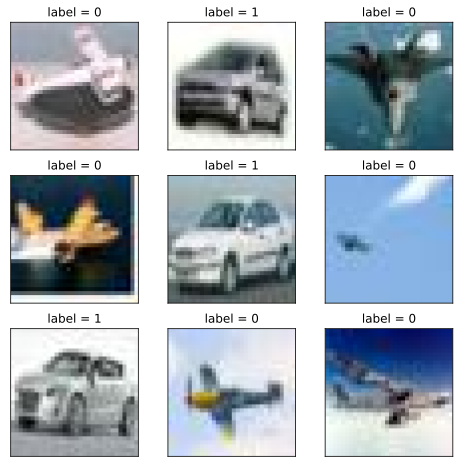

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i,(img,label) in enumerate(ds_train.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [4]:
for x, y in ds_train.take(1):
    print(x.shape, y.shape)

(100, 32, 32, 3) (100,)


In [5]:
tf.keras.backend.clear_session() #清空会话

inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0     

In [6]:
from datetime import datetime
log_dir = './log/1-2/{}'.format(datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])
history = model.fit(ds_train, epochs=10, validation_data=ds_test,
                    callbacks=[tensorboard_callback], workers=4)

Epoch 1/10
100/100 [==============================] - 4s 42ms/step - loss: 0.4304 - accuracy: 0.7910 - val_loss: 0.3075 - val_accuracy: 0.8705

In [11]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6007: logdir ./log/1-2 (started 9:31:56 ago; pid 27625)
  - port 6006: logdir ./log/1-2 (started 10:17:51 ago; pid 17545)


In [12]:
notebook.start('--logdir ./log/1-2')

Launching TensorBoard...

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend('train_'+metric, 'val_'+metric)
    plt.show()

<ipython-input-8-4d3fca2325b7>:14: UserWarning: The handle 'i' has a label of '_' which cannot be automatically added to the legend.
  plt.legend('train_'+metric, 'val_'+metric)
<ipython-input-8-4d3fca2325b7>:14: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('train_'+metric, 'val_'+metric)
<ipython-input-8-4d3fca2325b7>:14: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend('train_'+metric, 'val_'+metric)
<ipython-input-8-4d3fca2325b7>:14: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy

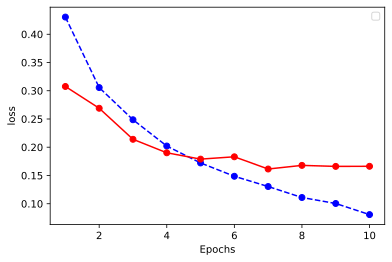

In [9]:
plot_metric(history, 'loss')